In [1]:
import cv2
import configparser
import numpy as np

import time

from utils import showarray, Feature_bank
from accelerator import LK_accelerator

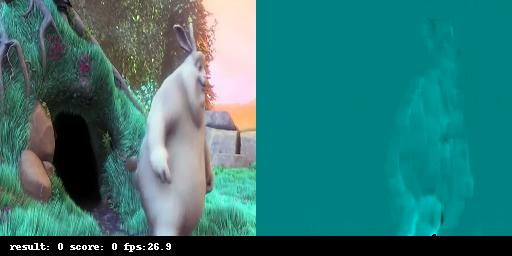

avg fps:26.488221095555822


In [2]:
size = (ch,h,w) = (20,256,256)

config = configparser.ConfigParser()
config.read('./files/config.config')

# LK acc, memory bank
lk_acc = LK_accelerator(config)
f_bank = Feature_bank(config)

fps_list = []
start,end,sec = 0,0,1e-4

# put demo video
cap = cv2.VideoCapture('files/Big.Buck.Bunny.mp4')

prev_frame = np.zeros((h,w))
while(True):
    start = time.time()
    
    ret,frame = cap.read()
    if ret:
        frame = cv2.resize(frame, (h, w))
        curr_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        vx,vy = lk_acc.compute(prev_frame, curr_frame)
        
        f_bank.push(vx,vy)
        
        feature_arr = f_bank.get_np_arr() #這邊吐出來是 np array(256,256,20)
        
        # TODO:
        # vgg16
        
        
        
        prev_frame = curr_frame
        
        ####################
        ##### just show ####
        vx = np.expand_dims(vx, axis=2)
        vy = np.expand_dims(vy, axis=2)
        #vv = np.sqrt((vx**2+vy**2))
        vv = np.zeros((h,w,1))
        v = np.concatenate((vv,vx,vy),axis=2).astype(np.uint8)
        showarray(np.concatenate((frame,v),axis=1), 1/sec)
        ####################
        #showarray(frame, 1/sec)
    else:
        break

    end = time.time()
    sec = end-start
    fps_list.append(1/sec)

print(f"avg fps:{sum(fps_list)/len(fps_list)}")

## Trashes

from pynq import Overlay
from pynq import Xlnk
xlnk = Xlnk()
xlnk.xlnk_reset()

overlay = Overlay('./files/design_1.bit')
LK_accelerator(32, 32, mode='unsigned', overlay=overlay)

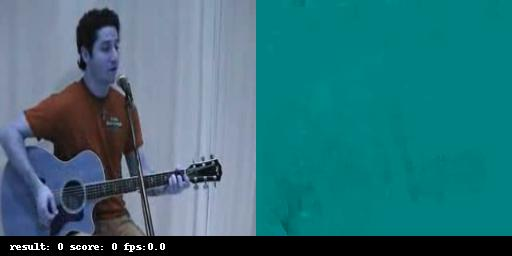

In [8]:
import os

size = (ch,h,w) = (20,256,256)

config = configparser.ConfigParser()
config.read('./files/config.config')

# LK acc, memory bank
lk_acc = LK_accelerator(config)
f_bank = Feature_bank(config)

os.system('mkdir -p files/output')

candidate = ['files/v_Biking_g01_c01.avi',
            'files/v_Biking_g01_c02.avi',
            'files/v_PlayingGuitar_g01_c01.avi',
            'files/v_PlayingGuitar_g01_c02.avi']

for video in candidate:
    # put demo video
    dir_ = video[video.find('files/')+6:video.find('.avi')]
    os.system(f'mkdir files/output/{dir_}')
    
    cap = cv2.VideoCapture(video)

    count = 0
    prev_frame = np.zeros((h,w))
    while(True):
        
        ret,frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (h, w))
            curr_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            vx,vy = lk_acc.compute(prev_frame, curr_frame)

            # TODO:
            # vgg16
            cv2.imwrite(f'files/output/{dir_}/{count}_vx.png', vx)
            cv2.imwrite(f'files/output/{dir_}/{count}_vy.png', vy)


            count += 1
            prev_frame = curr_frame

            ####################
            ##### just show ####
            vx = np.expand_dims(vx, axis=2)
            vy = np.expand_dims(vy, axis=2)
            #vv = np.sqrt((vx**2+vy**2))
            vv = np.zeros((h,w,1))
            v = np.concatenate((vv,vx,vy),axis=2).astype(np.uint8)
            showarray(np.concatenate((frame,v),axis=1), 0)
            ####################
            #showarray(frame, 1/sec)
        else:
            break

